## Libraries

In [139]:
'''Nath & Data Libraries'''
import numpy as np
import random
import pandas as pd

import netCDF4 as nc4

from scipy import signal

In [2]:
''' ML Libraries'''
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error

import pickle

In [127]:
from tqdm import tqdm

In [8]:
'''Visualization Libraries'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"grid.color": "0.5", "axes.edgecolor": "0.2"})
color_palette = ["#FF8853", "#FFE174", "#007597", "#C1C36D", "#00A697", "#BC97E0", "#ffc0bf"]

## Variables

In [9]:
model_dict = dict()
model_dict["IPSL"] = {'hist-GHG' : 10,'hist-aer' : 10, 'hist-nat' : 10,'historical' : 32}
model_dict["ACCESS"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 30}
model_dict["CESM2"] = {'hist-GHG' : 3,'hist-aer' : 2, 'hist-nat' : 3,'historical' : 11}
model_dict["BCC"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 3}
model_dict["CanESM5"] = {'hist-GHG' : 50,'hist-aer' : 30, 'hist-nat' : 50,'historical' : 65}
model_dict["FGOALS"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 6}
model_dict["HadGEM3"] = {'hist-GHG' : 4,'hist-aer' : 4, 'hist-nat' : 4,'historical' : 5}
model_dict["MIRO"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 50}
model_dict["ESM2"] = {'hist-GHG' : 5,'hist-aer' : 5, 'hist-nat' : 5,'historical' : 7}
model_dict["NorESM2"] = {'hist-GHG' : 3,'hist-aer' : 3, 'hist-nat' : 3,'historical' : 3}
model_dict["CNRM"] = {'hist-GHG' : 9,'hist-aer' : 10, 'hist-nat' : 10,'historical' : 30}
model_dict["GISS"] = {'hist-GHG' : 10,'hist-aer' : 12, 'hist-nat' : 20,'historical' : 19}

In [14]:
data_dir = '../data_pre_ind_2/' # Location of the data

In [93]:
model_list = ['CanESM5', 'CNRM', 'IPSL', 'ACCESS', 'BCC', 'FGOALS', 'HadGEM3', 'MIRO', 'ESM2','NorESM2','CESM2','GISS']

## Classes

In [124]:
class CNN_Model(nn.Module):
    """
    A class for a Convolutional Neural Network. 
    The CNN consists of three convolutional layers, each with a padding of 5 
    and a kernel size of 11 that are non-linearly transformed using a hyperbolic tangent function. 
    ---
    Parameters
    ----------
    size_channel : int
        length of the layer (number of neurons) (defaults to 10)  
    bias: boolean
        whether to add a learnable bias to the input (defaults to True)
    
    Methods
    -------
    forward(X):
        Defines the computation performed at every call.
    """
    def __init__(self, size_channel = 10, bias = True):
        super(CNN_Model, self).__init__()
        self.tanh = nn.Tanh()
        self.conv1 = nn.Conv1d(3, size_channel, kernel_size=11, bias=bias, padding=5) # The input layer has a size of 3 due to the three forcings [ghg, aer, nat]
        self.conv2 = nn.Conv1d(size_channel, size_channel, kernel_size=11, bias=bias, padding=5)
        self.conv3 = nn.Conv1d(size_channel, 1, kernel_size=11, bias=bias, padding=5) # The output layer has a size of 1 as the target [hist]

    def forward(self, x):
        """
        Defines the computation performed at every call.
        The input goes through 2 convolutional and hyperbolic tangent layers before being 
        transformed to float and transformed to a tensor of shape (batch_size, N_years)
        ---
        Parameters
        ----------
            x : torch.tensor of shape (batch_size, N_forcings, N_years), where the batch size defaults to 100, N_forcings equals 3 and represents the three forcings [ghg, aer, nat], and N_years equals 115 and represents the data from 1900-2014.
                input tensor containing the batch of data for the three forcings over the time span of interest.
        
        Returns
        -------
            Output of computation : torch.tensor of shape (batch_size, N_years)
                output tensor that tries to predict the historical simulations using all the external forcings as varying boundary conditions
        """
        x = self.conv1(x)
        x = self.tanh(x)
        x = self.conv2(x)
        x = self.tanh(x)
        x = x.float()
        x = self.conv3(x)[:,0,:]
        return x
    
class Linear_Model(nn.Module):
    """
    A class for a Simple Linear Module used for comparison. 
    ---
    Parameters
    ----------
    bias: boolean
        whether to add a learnable bias to the input (defaults to False)
    
    Methods
    -------
    forward(X):
        Defines the computation performed at every call.
    """
    def __init__(self, bias = False):
        super(Linear_Model, self).__init__()
        self.linear = nn.Linear(3, 1, bias = bias)

    def forward(self, X):
        """
        Defines the computation performed at every call.
        The input goes through a linear layer before being transformed to a tensor of shape [batch_size, N_years]
        ---
        Parameters
        ----------
            x : torch.tensor of size (batch_size, N_forcings, N_years), where the batch size defaults to 100, N_forcings equals 3 and represents the three forcings [ghg, aer, nat], and N_years equals 115 and represents the data from 1900-2014.
                input tensor containing the batch of data for the three forcings over the time span of interest.
        
        Returns
        -------
            Output of computation : torch.tensor of shape (batch_size, N_years)
                output tensor that tries to predict the historical simulations using all the external forcings as varying boundary conditions
        """
        x = self.linear(X.transpose(1,2))
        return x[:,:,0]

class MonDataset(Dataset):
    """
    A pytorch Dataset class that is used as an input for the CNN DataLoader. 
    ---
    Parameters
    ----------
    ghg: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the greenhouse gas (GHG) single forcing simulations for each model over the time span of interest.
    aer: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the aerosol (AER) single forcing simulations for each model over the time span of interest.
    nat: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 2 to 30, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the natural (NAT) single forcing simulations for each model over the time span of interest.
    historical: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 65, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the historical (HIST) simulations using all the external forcings as varying boundary conditions for each model over the time span of interest.
    model_of_interest: int
        The index of the model to exclude (include) when creating the train (test) dataset. Set to -1 in order to include all models.
    type: str, one of ["train", "test"]
        Whether to create a train or test dataset

    Methods
    -------
    len(N_samples):
        Defines the number of samples returned.
    __getitem__():
        Fetch a random data sample.
    """
    def __init__(self, ghg, aer, nat, historical, model_of_interest=-1, type='train'):
        self.ghg = ghg
        self.aer = aer
        self.nat = nat
        self.historical = historical
        self.type=type
        self.model_of_interest = model_of_interest

    def __len__(self, N_samples = 50000):
        """
        Defines the number of samples returned.
        ---
        Parameters
        ----------
            N_samples: int
                Number of samples to return. Defaults to 5e4.
                
        Returns
        -------
            Number of samples : int
        """
        return N_samples

    def __getitem__(self, idx):
        """
        Fetch a random data sample.
        If self.model_of_interest is -1, no models are excluded and in both the train and test sample we randomly choose a model and then randomly choose a simulation for each forcing to add to the dataset.   
        Otherwise, if we want to exclude a specific model, within the train set we randomly choose a model that is not the model we want to exclude, while in the test set we only acquire data from that model. 
        ---
        Returns
        -------
            X : torch.tensor of shape (N_forcings, N_years), where N_forcings equals 3 and represents the three forcings [ghg, aer, nat], and N_years equals 115 and represents the data from 1900-2014.
                a tensor containing a random sample of the simulation data for the three forcings over the time span of interest.
            y : torch.tensor of shape (N_years, ) where N_years equals 115 and represents the data from 1900-2014
                a tensor containing a random sample of the historical simulation data over the time span of interest.
            model_idx : int
                the index of the model used to acquire the random sample
        """
        if(self.type == 'train'):
            # We sample a random index between 0 and 11 until we find one that is not the model we want to exclude. 
            while True:
                model_idx = random.randint(0, len(self.ghg) - 1)
                if(model_idx != self.model_of_interest): 
                    break

        elif(self.type == 'test'):
            # We take the index of the model we want to include. 
            model_idx = self.model_of_interest
            # If the model is -1, then all models can potentially be included, thus we randomly sample one of the 12 models
            if(model_idx==-1):
                model_idx = random.randint(0, len(self.ghg) - 1)

        #We sample a simulation of each forcing of the model
        ghg_sample = self.ghg[model_idx][random.randint(0, self.ghg[model_idx].shape[0] - 1)]
        aer_sample = self.aer[model_idx][random.randint(0, self.aer[model_idx].shape[0] - 1)]
        nat_sample = self.nat[model_idx][random.randint(0, self.nat[model_idx].shape[0] - 1)]
        hist_sample = self.historical[model_idx][random.randint(0, self.historical[model_idx].shape[0] - 1)]
        X = torch.stack((ghg_sample, aer_sample, nat_sample)).float()
        y = hist_sample.float()

        return X, y, model_idx


## Functions

In [141]:
def calculate_spatial_mean(data):
    """
    Calculate the spatially weighted mean over the globe. 
    ---
    Parameters
    ----------
    data : np.array of shape (N_years, latitude, longitude)
        temporal data covering the entire globe

    Returns
    -------
        obs_data_mean : np.array of shape (N_years)
            Annual spatially averaged observation data from 1900 to 2020.
    """
    data_mean = np.zeros((data.shape[0])) #Initialize np array to keep the results
    latitude = np.linspace(-87.5, 87.5, 36) #Initialize array that contains the latitude coordinates used in the spatial weighting
    div = 0 

    for j in range(36):
        for k in range(72):
            data_mean += data[:,j,k] * np.cos(np.radians(latitude[j])) 
            div += np.cos(np.radians(latitude[j]))
        data_mean /= div
    return data_mean

def get_observation_data():
    """
    Get annual observation (OBS) data of the 2 m air temperature over the continent from HadCRUT4 (Morice et al., 2012) 
    blended with sea surface temperature from HadISST4 (Rayner et al., 2003) over the time span of interest. The data is spatially averaged 
    ---
    Returns
    -------
        obs_data_mean : np.array of shape (121, )
            Annual spatially averaged observation data from 1900 to 2020.
    """
    obs_nc = nc4.Dataset(data_dir + 'obs.nc', 'r')
    obs_temperature_data = obs_nc.variables['temperature_anomaly'][:]
    return calculate_spatial_mean(obs_temperature_data)

def calculate_preindustrial_average(forcing, model_name = 'IPSL', physics = 1):
    """
    Calculate pre-industrial average between years 1850-1900 for a given forcing and model.
    ---
    Parameters
    ----------
    forcing : str: one of ["hist-GHG", "hist-aer", "hist-nat", "historical"]
        type of forcing used in the simulation
    model_name : str: one of the 12 models in the model_list
        model used in the simulation
    physics: int: one of [1, 2]
        parameter used for the GISS model

    Returns
    -------
        preindustrial_average : float
            The pre-industrial average between the years 1850-1900.
    """
    # Since there are special rules for the GISS model it has to be done like this. Think of ways to make it simpler

    preindustrial_average = np.zeros((36,72))
    if(model_name=="GISS"):
        if(type=='hist-aer'):
            if(physics==1):
                for i in range(model_dict[model_name][forcing]):
                    if(i<5 or i>9):
                        simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                        simu_temperature_data = simu_nc.variables['tas'][0:50]
                        preindustrial_average += np.mean(simu_temperature_data, axis=0)/7
            else:  
                for i in range(model_dict[model_name][forcing]):
                    if(i>=5 and i<=9):
                        simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                        simu_temperature_data = simu_nc.variables['tas'][0:50]
                        preindustrial_average += np.mean(simu_temperature_data, axis=0)/5
        if(type=='historical'):
            if(physics==1):
                for i in range(model_dict[model_name][forcing]):
                    if(i<10):
                        simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                        simu_temperature_data = simu_nc.variables['tas'][0:50]
                        preindustrial_average += np.mean(simu_temperature_data, axis=0)/10
            else:
                for i in range(model_dict[model_name][forcing]):
                    if (i>=10):
                        simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                        simu_temperature_data = simu_nc.variables['tas'][0:50]
                        preindustrial_average += np.mean(simu_temperature_data, axis=0)/9
        else:
            for i in range(model_dict[model_name][forcing]):
                if (i>=5 and i<=9):
                    simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
                    simu_temperature_data = simu_nc.variables['tas'][0:50]
                    preindustrial_average += np.mean(simu_temperature_data, axis=0)/5
    else:
        for i in range(model_dict[model_name][forcing]):
            simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{i+1}.nc", 'r')
            simu_temperature_data = simu_nc.variables['tas'][0:50]
            preindustrial_average += np.mean(simu_temperature_data, axis=0)/model_dict[model_name][forcing]
    return preindustrial_average

def get_simulation(simulation_index, forcing, model_name = 'IPSL', filter = False):
    """
    Get a simulation for a given forcing and model. 
    ---
    Parameters
    ----------
    simulation_index : int
        the index of the requested simulation 
    forcing : str: one of ["hist-GHG", "hist-aer", "hist-nat", "historical"]
        type of forcing used in the simulation
    model_name : str: one of the 12 models in the model_list
        model used in the simulation
    filter : boolean. Defaults to False.
        whether to apply a lowpass filter to the GHG and AER forcings 

    Returns
    -------
        simulation : np.array of shape (N_years), where N_years equals 115
            The data from one simulation for a given forcing and climate model for the years 1900-2014, from which the pre-industrial average is excluded.
    """

    # Calculate pre-industrial average
    physics = 1 
    if(model_name=='GISS'):
        if(forcing=='hist-aer' and (simulation_index>=6 and simulation_index<=10)):
            physics = 2
        elif(forcing=='historical' and simulation_index>10):
            physics = 2
    preindustrial_average = calculate_preindustrial_average(forcing, model_name = model_name, physics = physics)

    # Calculate post-industrial 1900-2015 average
    simu_nc = nc4.Dataset(f"{data_dir}{model_name}_{forcing}_{simulation_index}.nc", 'r')
    simu_temperature_data = simu_nc.variables['tas'][50:]

    # Subtract preindustrial average from the post-industrial data
    preindustrial_average += np.mean(simu_temperature_data, axis=0)/7

    simu_temperature_data = simu_temperature_data - preindustrial_average
    simulation = calculate_spatial_mean(simu_temperature_data)
    
    if(filter):
        if(forcing=='hist-GHG' or forcing=='hist-aer'):
            b, a = signal.butter(20, 1/5, btype='lowpass') # Lowpass used in the filtrage of the data
            simulation = signal.filtfilt(b, a, simulation)
    return simulation

def get_all_simulations(forcing, model_name = 'IPSL',filter = False):
    """
    Get all simulations for a given forcing and model. 
    ---
    Parameters
    ----------
    forcing : str: one of ["hist-GHG", "hist-aer", "hist-nat", "historical"]
        type of forcing used in the simulation
    model_name : str: one of the 12 models in the model_list
        model used in the simulation
    filter : boolean. Defaults to False.
        whether to apply a lowpass filter to the GHG and AER forcings 

    Returns
    -------
        simulation_data : np.array of shape (N_simu, N_years), where N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014 
            The data from all simulations for a given forcing and climate model for the years 1900-2014, from which the pre-industrial average is excluded.
    """

    simulation_data = np.zeros((model_dict[model_name][forcing], 115))
    for i in range(model_dict[model_name][forcing]):
        simulation_data[i] = get_simulation(i+1, forcing = forcing, model_name = model_name, filter = filter)[0:115]
    return (simulation_data)

def get_model_dataset(model_name = 'ALL', normalize = True, filter = False):
    """
    Get the entire dataset (all simulations for all forcings) for a climate model. 
    ---
    Parameters
    ----------
    model_name : str: one of the 12 models in the model_list or "ALL" to acquire dataset for all climate models
        model used in the simulation
    normalize : boolean. Defaults to False.
        whether to normalize all simulations by the maximum historical value 
    filter : boolean. Defaults to False.
        whether to apply a lowpass filter to the GHG and AER forcings 

    Returns
    -------
    ghg: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the greenhouse gas (GHG) single forcing simulations for each model over the time span of interest.
    aer: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 50, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the aerosol (AER) single forcing simulations for each model over the time span of interest.
    nat: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 2 to 30, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the natural (NAT) single forcing simulations for each model over the time span of interest.
    historical: list of length 12, with one torch.tensor of shape (N_simu, N_years) for each model. N_simu is dependent on the model and ranges from 3 to 65, and N_years equals 115 and represents the data from 1900-2014  
        A list of tensors, containing the historical (HIST) simulations using all the external forcings as varying boundary conditions for each model over the time span of interest.
    maximum_historical_list: list of length 1 or length 12, dependent if model_name=="ALL" 
        A list of maximum historical values per model    
    """
    maximum_historical_list = []
    
    if (model_name == 'ALL'):
        aer = []
        ghg = []
        nat = []
        historical = []

        for model_curr in tqdm(model_list):
            print(model_curr)
            aer_curr = torch.tensor(get_all_simulations('hist-aer', model_name = model_curr, filter = filter)[:, 0:115])
            ghg_curr = torch.tensor(get_all_simulations('hist-GHG', model_name = model_curr, filter = filter)[:, 0:115])
            nat_curr = torch.tensor(get_all_simulations('hist-nat', model_name = model_curr, filter = filter)[:, 0:115])
            historical_curr = torch.tensor(get_all_simulations('historical', model_name = model_curr, filter = filter)[:, 0:115])
            historical_max = torch.max(torch.mean(historical_curr, dim=0))
            maximum_historical_list.append(historical_max)

            if(normalize):
                aer_curr = aer_curr / historical_max
                ghg_curr = ghg_curr / historical_max
                nat_curr = nat_curr / historical_max
                historical_curr = historical_curr / historical_max

            aer.append(aer_curr)
            ghg.append(ghg_curr)
            nat.append(nat_curr)
            historical.append(historical_curr)

    else:
        aer = torch.tensor(get_all_simulations('hist-aer', model_name = model_name, filter = filter)[:,0:115])
        ghg = torch.tensor(get_all_simulations('hist-GHG', model_name = model_name, filter = filter)[:,0:115])
        nat = torch.tensor(get_all_simulations('hist-nat', model_name = model_name, filter = filter)[:,0:115])
        historical = torch.tensor(get_all_simulations('historical', model_name = model_name, filter = filter)[:,0:115])
        historical_max = torch.max(torch.mean(historical, dim=0))
        maximum_historical_list.append(historical_max)

        if(normalize):
            aer = aer /historical_max
            ghg = ghg / historical_max
            nat = nat / historical_max
            historical = historical/ historical_max

    return ghg, aer, nat, historical, np.array(maximum_historical_list)
    
def train_models(train_dataloader, test_dataloader, lr = 0.001, N_epoch = 100, size_channel = 10, regularization = 0):
    """
    Train the CNN and Linear model. 
    ---
    Parameters
    ----------
    train_dataloader : pytorch Dataloader
        the data loader for the training set that consists of a sample of simulations from the three forcings for random climate models.
    test_dataloader : pytorch Dataloader
        the data loader for the test set that consists of a sample of simulations from the three forcings for random climate models.
    lr : int
        learning rate. Defaults to 1e-3.
    N_epoch : int
        the number of epochs used to train the model. Defaults to 1e2.
    size_channel : int
        length of the layer (number of neurons) (defaults to 10)  
    regularization : float
        the amount of regularization used when training the model. Defaults to 0, representing no regularization. 

    Returns
    model, Loss_tab,Loss_test_tab, model_linear, Loss_tab_lin,Loss_test_tab_lin
    -------
    model_CNN : CNN_Model
        a CNN model which takes data from the three single forcing models [ghg, aer, nat] and is trained to predict the historical (HIST) simulations using all the external forcings as varying boundary conditions
    loss_train_CNN: list of length N_epoch
        list that contains the MSE loss of the model on the training set after each epoch 
    loss_test_CNN: list of length N_epoch
        list that contains the MSE loss of the model on the test set after each epoch 
    model_linear : Linear_Model
        a benchmark linear model which takes data from the three single forcing models [ghg, aer, nat] and is trained to predict the historical (HIST) simulations using all the external forcings as varying boundary conditions
    loss_train_linear: list of length N_epoch
        list that contains the MSE loss of the model on the training set after each epoch 
    loss_test_linear: list of length N_epoch
        list that contains the MSE loss of the model on the test set after each epoch 
    """

    model_CNN = CNN_Model(size_channel = size_channel, bias = True)
    model_linear = Linear_Model(bias = False)

    criterion_CNN = nn.MSELoss()
    criterion_linear = nn.MSELoss()

    optim_CNN = torch.optim.Adam(model_CNN.parameters(), lr=lr, weight_decay = regularization)
    optim_linear = torch.optim.Adam(model_linear.parameters(), lr=lr, weight_decay=regularization)

    loss_train_CNN = []
    loss_test_CNN = []

    loss_train_linear = []
    loss_test_linear = []

    for iter in tqdm(range(N_epoch)):
        loss_total_train_CNN = 0
        loss_total_test_CNN = 0
        length_train_CNN = 0
        length_test_CNN = 0

        loss_total_train_linear = 0
        loss_total_test_linear = 0
        length_train_linear = 0
        length_test_linear = 0

        with torch.no_grad():
            for(X_test, y_test, model_idx) in test_dataloader:
                y_hat_test_CNN = model_CNN(X_test)
                loss_test = criterion_CNN(y_hat_test_CNN.float(), y_test.float())
                loss_total_test_CNN += loss_test
                length_test_CNN += 1

                y_hat_test_linear = model_linear(X_test)
                loss_test = criterion_linear(y_hat_test_linear.float(),y_test.float())
                loss_total_test_linear += loss_test
                length_test_linear += 1

        for(X_train, y_train, model_idx) in train_dataloader:
            y_hat_train_CNN = model_CNN(X_train)
            loss = criterion_CNN(y_hat_train_CNN.float(), y_train.float())
            loss.backward()
            optim_CNN.step()
            loss_total_train_CNN += loss
            optim_CNN.zero_grad()
            length_train_CNN +=1

            y_hat_train_linear = model_linear(X_train)
            loss = criterion_linear(y_hat_train_linear.float(), y_train.float())
            loss.backward()
            optim_linear.step()
            loss_total_train_linear += loss
            optim_linear.zero_grad()
            length_train_linear += 1

        loss_total_train_CNN = loss_total_train_CNN.item() / length_train_CNN
        loss_total_test_CNN = loss_total_test_CNN.item() / length_test_CNN
        loss_total_train_linear = loss_total_train_linear.item() / length_train_linear
        loss_total_test_linear = loss_total_test_linear.item() / length_test_linear

        if(iter%10 == 0):
            print(f"Iteration {iter}:")
            print(f"\tCNN: training loss: {loss_total_train_CNN:.6f}, test loss {loss_total_test_CNN:.6f}")
            print(f"\tLinear: training loss: {loss_total_train_linear:.6f}, test loss {loss_total_test_linear:.6f}")

        loss_train_CNN.append(loss_total_train_CNN)
        loss_test_CNN.append(loss_total_test_CNN)

        loss_train_linear.append(loss_total_train_linear)
        loss_test_linear.append(loss_total_test_linear)

    return model_CNN, np.array(loss_train_CNN), np.array(loss_test_CNN), model_linear, np.array(loss_train_linear), np.array(loss_test_linear)

# Pipeline

## Data

In [213]:
# Get observation data
observation_data = torch.tensor(get_observation_data())[0:115] * 1.06
# observation_max = torch.max(observation_data)
# observation_data = observation_data /observation_max

# Get climate model simulation data
ghg, aer, nat, historical, maximum_historical_list = get_model_dataset(model_name = 'ALL', normalize = False, filter = False)

  0%|          | 0/12 [00:00<?, ?it/s]

CanESM5


  8%|▊         | 1/12 [00:46<08:28, 46.21s/it]

CNRM


 17%|█▋        | 2/12 [00:53<03:53, 23.34s/it]

IPSL


 25%|██▌       | 3/12 [01:01<02:28, 16.45s/it]

ACCESS


 33%|███▎      | 4/12 [01:07<01:37, 12.17s/it]

BCC


 42%|████▏     | 5/12 [01:08<00:56,  8.12s/it]

FGOALS


 50%|█████     | 6/12 [01:09<00:34,  5.75s/it]

HadGEM3


 58%|█████▊    | 7/12 [01:11<00:22,  4.41s/it]

MIRO


 67%|██████▋   | 8/12 [01:23<00:27,  6.94s/it]

ESM2


 75%|███████▌  | 9/12 [01:25<00:16,  5.41s/it]

NorESM2


 83%|████████▎ | 10/12 [01:26<00:08,  4.07s/it]

CESM2


 92%|█████████▏| 11/12 [01:28<00:03,  3.37s/it]

GISS


100%|██████████| 12/12 [01:33<00:00,  7.78s/it]


In [214]:
N_simu_table_list = []
for i in range(len(model_list)):
    N_simu_table_list.append([model_list[i], ghg[i].shape[0], aer[i].shape[0], nat[i].shape[0], historical[i].shape[0]])
N_simu_table = pd.DataFrame(N_simu_table_list, columns = ["Model Name", "#GHG", "#AER", "#NAT", "#HIST"])
N_simu_table

,Model Name,#GHG,#AER,#NAT,#HIST
0,CanESM5,50,30,50,65
1,CNRM,9,10,10,30
2,IPSL,10,10,10,32
3,ACCESS,3,3,3,30
4,BCC,3,3,3,3
5,FGOALS,3,3,3,6
6,HadGEM3,4,4,4,5
7,MIRO,3,3,3,50
8,ESM2,5,5,5,7
9,NorESM2,3,3,3,3


In [215]:
observation_data

tensor([ 2.2014e-04,  1.5156e-04, -5.1507e-04,  4.9064e-04,  3.5181e-04,
         3.2485e-04,  8.4341e-04,  8.6830e-04,  2.7761e-04, -9.1392e-05,
        -1.9109e-04,  6.2386e-04, -1.1280e-03, -2.3726e-04, -2.6803e-04,
        -4.9750e-04, -8.1556e-04, -2.0949e-03, -8.2432e-04, -2.8902e-04,
         9.5304e-04,  5.9721e-04,  9.7430e-04,  1.3494e-03,  1.3085e-03,
         7.6208e-04,  1.1300e-03,  8.3834e-04,  1.5990e-03,  6.4050e-04,
         2.1534e-03,  2.4582e-03,  2.0529e-03,  2.5226e-03,  2.7804e-03,
         2.0206e-03,  2.5433e-03,  3.3754e-03,  5.1002e-03,  2.0706e-03,
         3.2002e-03,  1.5963e-03,  2.7057e-03,  2.7791e-03,  3.5120e-03,
         2.6457e-03,  1.6051e-03,  3.9872e-03,  4.1546e-04,  1.7568e-03,
         2.0219e-03,  1.5050e-03,  3.4580e-03,  3.9315e-03,  3.6409e-03,
         1.8286e-03,  2.9623e-03,  1.1966e-03,  2.4270e-03,  2.7082e-03,
         2.1419e-03,  9.3495e-04,  1.4718e-03, -8.2538e-04, -3.1670e-04,
         1.5869e-03,  1.4034e-04,  1.6780e-03, -2.1

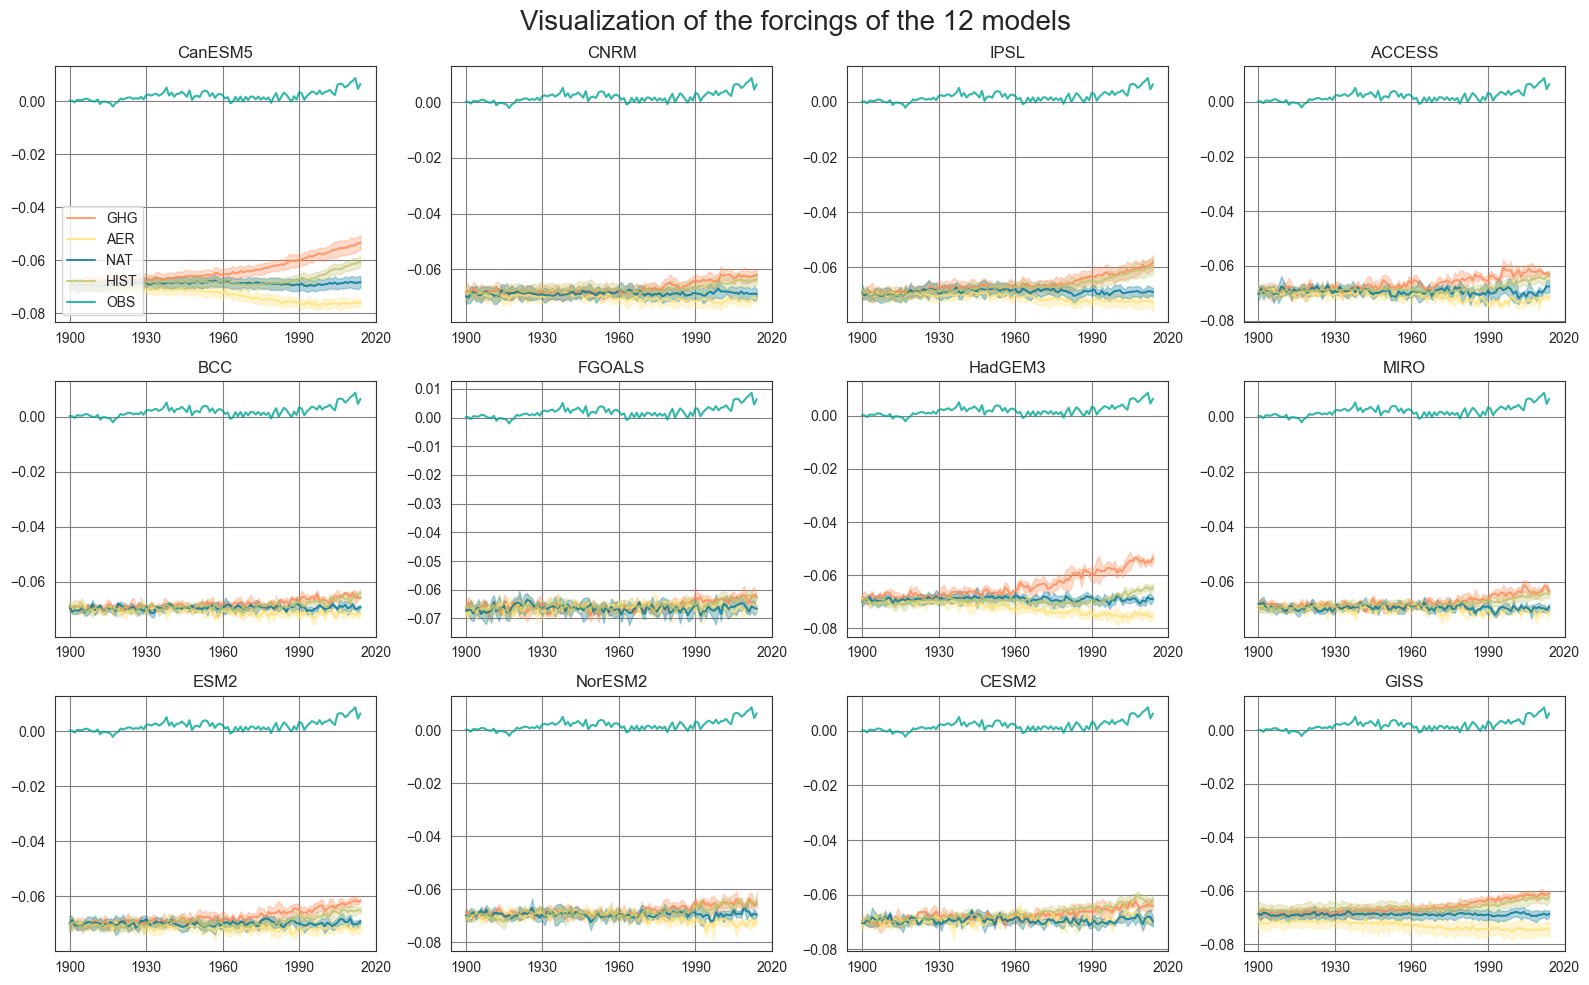

In [217]:
colors_model = ['red','blue','green','purple','gray','yellow','brown','orange','lawngreen','cyan','pink','olive']

fig, ax = plt.subplots(figsize = (16,10), ncols = 4, nrows = 3)
plt.suptitle("Visualization of the forcings of the 12 models", fontsize = 20)
for i in range(len(model_list)):
    plt.subplot(3, 4, i+1)
    plt.title(model_list[i])
    for j, (forcing, forcing_name) in enumerate(zip([ghg, aer, nat, historical], ["GHG", "AER", "NAT", "HIST"])):
        plt.plot(torch.mean(forcing[i], axis=0), color = color_palette[j], alpha = 0.8, label = forcing_name)
        plt.fill_between(np.arange(115), torch.mean(forcing[i], axis=0) - torch.std(forcing[i], axis=0), torch.mean(forcing[i], axis=0) + torch.std(forcing[i], axis=0), color = color_palette[j], alpha = 0.3)
    plt.plot(observation_data, color = color_palette[4], alpha = 0.8, label = "OBS")

    # plt.ylim(0.9, 1.3)
    plt.xticks(np.linspace(0, 120, 5), [str(tick+1900) for tick in np.linspace(0, 120, 5, dtype=int)])
    # plt.yticks(np.linspace(0.9, 1.3, 5), [str(np.round(tick, 2)) for tick in np.linspace(0.9, 1.3, 5, dtype=float)])

    if(i==0):
        handles, labels = ax[0,0].get_legend_handles_labels()
        plt.legend(handles, ["GHG", "AER", "NAT", "HIST", "OBS"], loc = "lower left", fontsize = 10)
plt.tight_layout()
plt.show()


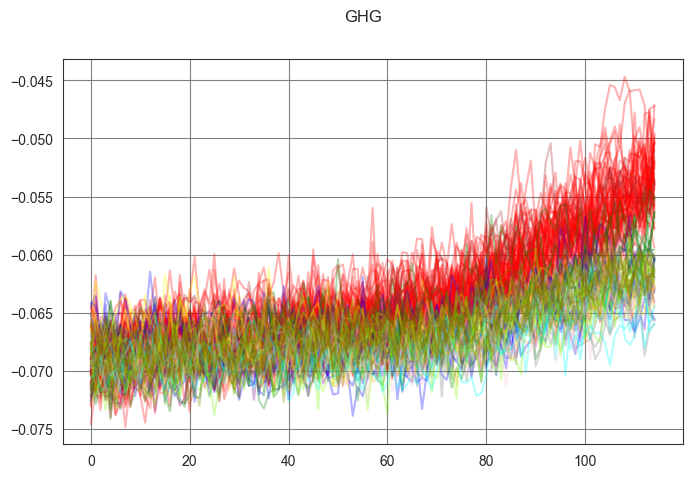

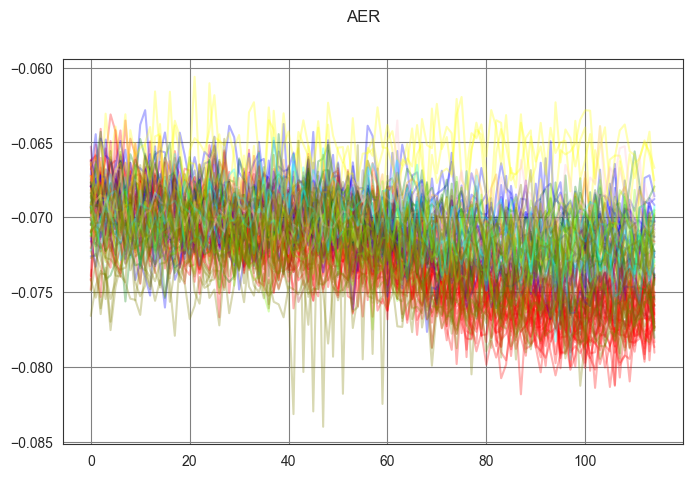

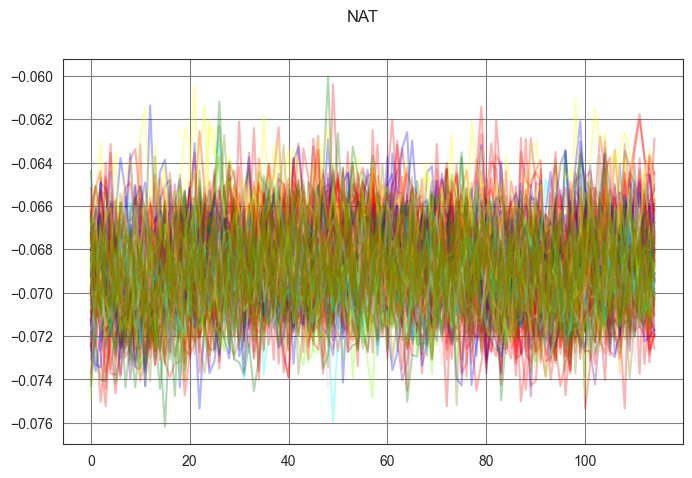

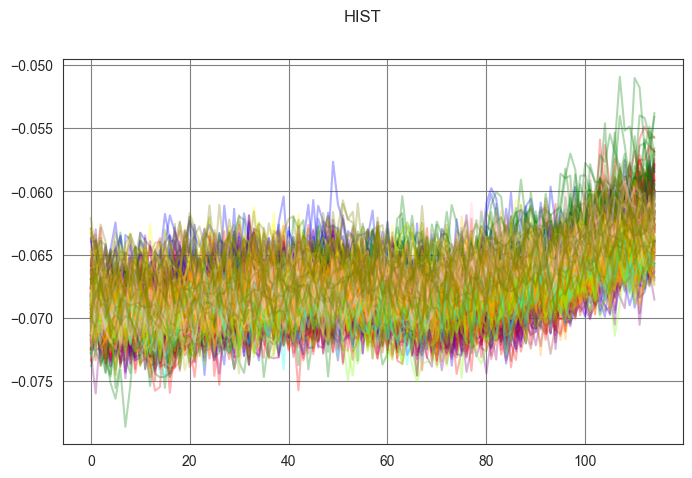

In [212]:
colors_model = ['red','blue','green','purple','gray','yellow','brown','orange','lawngreen','cyan','pink','olive']

for forcing, forcing_name in zip([ghg, aer, nat, historical], ["GHG", "AER", "NAT", "HIST"]):
    fig, ax = plt.subplots(figsize=(8,5))
    plt.suptitle(forcing_name)
    for i in range(len(forcing)):
        for j in range(len(forcing[i])):
            plt.plot(forcing[i][j], color = colors_model[i], alpha = 0.3)
        # break
    plt.show()

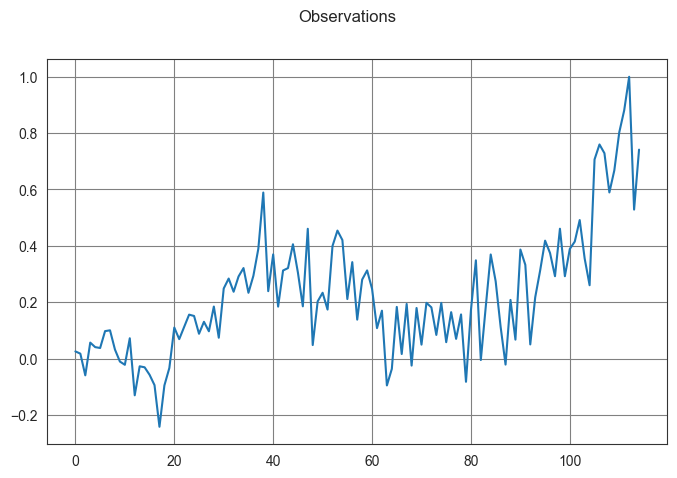

In [109]:
fig, ax = plt.subplots(figsize=(8,5))
plt.suptitle("Observations")
plt.plot(observation_data)
plt.show()

## CNN

In [128]:
BATCH_SIZE = 100
train_dataloader = DataLoader(MonDataset(ghg, aer, nat, historical, model_of_interest = -1, type = 'train'), shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(MonDataset(ghg, aer, nat, historical, model_of_interest = -1, type = 'test'), shuffle=True, batch_size=BATCH_SIZE)

In [135]:
model_CNN, loss_train_CNN, loss_test_CNN, model_linear, loss_train_linear, loss_test_linear = train_models(train_dataloader, test_dataloader, N_epoch = 100)

  1%|          | 1/100 [00:06<11:19,  6.86s/it]

Iteration 0:
	CNN: training loss: 0.015697, test loss 0.971950
	Linear: training loss: 0.165708, test loss 0.770492


 11%|█         | 11/100 [01:06<08:43,  5.88s/it]

Iteration 10:
	CNN: training loss: 0.001273, test loss 0.001356
	Linear: training loss: 0.002001, test loss 0.002014


 21%|██        | 21/100 [02:05<07:46,  5.90s/it]

Iteration 20:
	CNN: training loss: 0.001215, test loss 0.001179
	Linear: training loss: 0.001683, test loss 0.001691


 31%|███       | 31/100 [03:04<06:48,  5.92s/it]

Iteration 30:
	CNN: training loss: 0.001164, test loss 0.001175
	Linear: training loss: 0.001687, test loss 0.001688


 41%|████      | 41/100 [04:03<05:46,  5.87s/it]

Iteration 40:
	CNN: training loss: 0.001141, test loss 0.001125
	Linear: training loss: 0.001685, test loss 0.001689


 51%|█████     | 51/100 [05:02<04:48,  5.88s/it]

Iteration 50:
	CNN: training loss: 0.001137, test loss 0.001200
	Linear: training loss: 0.001690, test loss 0.001688


 61%|██████    | 61/100 [06:00<03:49,  5.87s/it]

Iteration 60:
	CNN: training loss: 0.001131, test loss 0.001214
	Linear: training loss: 0.001702, test loss 0.001682


 71%|███████   | 71/100 [06:59<02:50,  5.89s/it]

Iteration 70:
	CNN: training loss: 0.001120, test loss 0.001088
	Linear: training loss: 0.001689, test loss 0.001699


 81%|████████  | 81/100 [08:02<02:09,  6.79s/it]

Iteration 80:
	CNN: training loss: 0.001122, test loss 0.001090
	Linear: training loss: 0.001686, test loss 0.001686


 91%|█████████ | 91/100 [09:20<01:10,  7.83s/it]

Iteration 90:
	CNN: training loss: 0.001111, test loss 0.001308
	Linear: training loss: 0.001691, test loss 0.001684


100%|██████████| 100/100 [10:29<00:00,  6.29s/it]


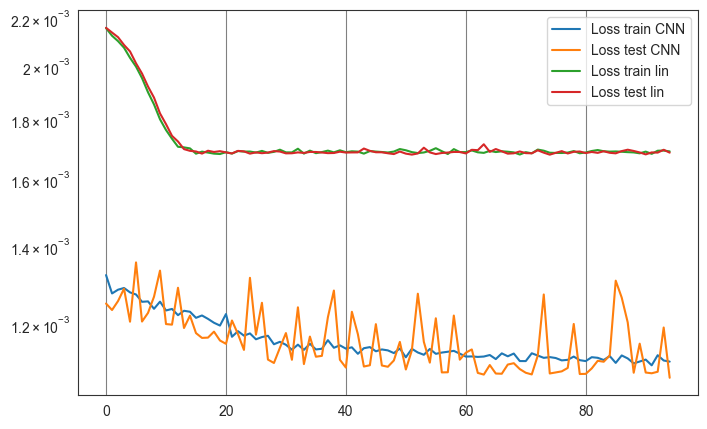

In [137]:
plt.figure(figsize=(8,5))
skip_first = 5
plt.plot(loss_train_CNN[skip_first:], label = "Loss train CNN")
plt.plot(loss_test_CNN[skip_first:], label = "Loss test CNN")
plt.plot(loss_train_linear[skip_first:], label = "Loss train lin")
plt.plot(loss_test_linear[skip_first:], label = "Loss test lin")
plt.yscale("log")
plt.legend()
plt.show()